# Tutorial: Qiskit-Braket provider overview

In [64]:
import os

from qiskit.algorithms import VQE
from qiskit.opflow import (
    I,
    X,
    Z,
)
from qiskit import transpile
from qiskit.circuit.random import random_circuit
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

from braket.aws import AwsQuantumJob

from qiskit_braket_provider import AWSBraketProvider, BraketLocalBackend

### Qiskit to Braket mapping

![qiskit-to-braket-diagram](./data/qiskit-to-braket-diagram.png)

### Access Braket devices from Qiskit 

Provider class to access AWS devices. Local simulator to use Braket SDK local simulator. 

In [8]:
provider = AWSBraketProvider()
backends = provider.backends()
backends

[BraketBackend[Aspen-10],
 BraketBackend[Aspen-11],
 BraketBackend[Aspen-8],
 BraketBackend[Aspen-9],
 BraketBackend[Aspen-M-1],
 BraketBackend[IonQ Device],
 BraketBackend[Lucy],
 BraketBackend[SV1],
 BraketBackend[TN1],
 BraketBackend[dm1]]

In [33]:
# local simulator
local_simulator = BraketLocalBackend()

# remote simulator
aws_statevector_simulator = provider.get_backend("SV1")

# devices
ionq_device = provider.get_backend("IonQ Device")
rigetti_device = provider.get_backend("Aspen-M-1")

# queries
online_simulators_backends = provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])
online_simulators_backends

[BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]

### Running circuits on AWS devices



In [20]:
# generate random circuit
circuit = random_circuit(6, 20, seed=42)
circuit.draw(fold=-1)

┌───┐        ┌───┐                                          ┌──────────────────────────┐┌──────────────┐                                                                                                   ┌─────────────┐    ┌───┐                                                                                           ┌───────────────────┐┌────────────┐┌────────────┐                                                                     
q_0: ───┤ T ├────────┤ S ├───────────────────X───■───────────■──────┤ U3(4.2086,2.7467,5.2319) ├┤ Rx(0.046259) ├──────────────────────────────────■────────────────────────────────────────X───────────■───────────┤ Ry(0.95701) ├────┤ Y ├───────■─────────■─────────────────────────────────────────■───────────────────────■───────┤ U2(3.0304,4.9181) ├┤ Rz(1.6775) ├┤ U1(4.2238) ├────────────────────────────────────────────────────────■────────────
     ┌──┴───┴───┐    └───┘                   │ ┌─┴─┐         │      └──────────────────────────┘└──────────────┘┌─────┐┌────────────────────────┐ │           ┌──────────────────────────┐ │           │           └┬────────────┤    └───┘       │         │             ┌───┐                       │                       │       └───────────────────┘└─────┬──────┘└────────────┘┌─────┐                             ┌────────────┐      │            
q_1: ┤ U1(6.13) ├────────────────────X───────X─┤ X ├─────────┼───────────────────X─────────────────────X────────┤ Tdg ├┤ U3(2.96,3.5515,4.8066) ├─┼───────────┤ U3(0.36633,1.768,1.8447) ├─┼───────────■────────────┤ Rz(2.8033) ├─■──────────────┼────■────┼─────────────┤ T ├───────────────────■───┼───────────────────────■─────────────────■────────────────┼─────────────■───────┤ Sdg ├─────────────────────────────┤ Rz(5.2137) ├──────┼────────────
     └──────────┘┌────────────┐      │       │ └─┬─┘         │                   │                     │        ├─────┤└───────────┬────────────┘ │U1(3.4782) └──────────┬───┬───────────┘ │         ┌─┴─┐          └─────┬──────┘ │ZZ(0.74145)   │    │    │  ┌──────────┴───┴───────────┐┌───┐  │   │                       │                 │                │           ┌─┴─┐     └┬───┬┘                             └─────┬──────┘      │            
q_2: ─────X──────┤ Ry(4.0455) ├──────┼───■───┼───┼───■───────┼───────────────────X─────────────────────X────────┤ Sdg ├────────────┼──────────────■──────────────────────┤ Z ├─────────────┼─────────┤ X ├────────────────■────────■──────────────┼────■────┼──┤ U3(1.9224,3.6393,1.1107) ├┤ Y ├──┼───┼─────────────■─────────┼─────────────────■────────────────┼───────────┤ X ├──────┤ X ├────────────────────────────────────┼─────────────┼─────────■──
          │      └───┬───┬────┘      │   │   │   │   │       │                   │                   ┌───┐      ├─────┤            │                 ┌───┐               └───┘             │         ├───┤              ┌───┐                     │  ┌─┴─┐  │  └──────────────────────────┘└─┬─┘  │   │           ┌─┴─┐       │                                  │           └─┬─┘      └───┘ ┌───────────────────────────┐      │             │       ┌─┴─┐
q_3: ─────┼──────────┤ T ├───────■───┼───┼───■───┼───X───────┼───────────────────■───────────────────┤ X ├──────┤ Tdg ├────────────■─────────────────┤ Z ├─────────────────────────────────┼─────────┤ H ├──────────────┤ X ├───────────■─────────┼──┤ X ├──■────────────────────────────────■────┼───┼───────────┤ Y ├───────┼─────────────────■────────────────■─────────────┼──────────────┤ U3(4.8296,0.67696,5.7555) ├──────┼─────────────┼───────┤ Y ├
          │          └───┘       │   │ ┌─┴─┐     │   │     ┌─┴─┐               ┌───┐                 └───┘      ├─────┤                              └───┘                                 │         └─┬─┘              └─┬─┘           │       ┌─┴─┐└───┘┌─┴─┐                                 ┌─┴─┐ │           └───┘     ┌─┴─┐         ┌─────┴──────┐       ┌───┐           │        ┌───┐ └─────────────┬─────────────┘      │       ┌─────┴──────┐└───┘
q_4

In [35]:
# transpile circuit
transpiled_circuit = transpile(circuit, backend=ionq_device, seed_transpiler=42)
transpiled_circuit.draw(idle_wires=False, fold=-1)

global phase: 0.90525
       ┌──────────┐                                                                                                   ┌───┐   ┌───┐     ┌─────┐  ┌───┐ ┌───┐ ┌───┐┌─────┐┌───┐ ┌───┐  ┌───┐                                                        ┌───┐            ┌───┐ ┌─────┐┌───┐                 ┌────────────┐┌────────────┐┌────────────┐                                                                                                                                                                            ┌───┐                                                                   ┌───┐      ┌───┐┌─────┐┌───┐     ┌───┐                                                             ┌───┐          ┌─────────────┐                                                                                                                                                                                            ┌───┐                                                                     ┌───┐      ┌───┐┌─────┐┌───┐┌────────────┐                                                                                              ┌───┐                         ┌─────────────┐       ┌─────────┐       ┌─────────────┐               ┌───┐┌────────────────────────┐┌───┐┌─────────────┐                                                                                                                                                                                                             
q_0: ──┤ Rz(3π/4) ├───────────────────────────────────────────────────────────────────────────────────────────■───────┤ H ├───┤ X ├─────┤ Tdg ├──┤ X ├─┤ T ├─┤ X ├┤ Tdg ├┤ X ├─┤ T ├──┤ H ├────────■─────────■────────────────────────────────■────┤ T ├────────────┤ X ├─┤ Tdg ├┤ X ├──────────────■──┤ Rz(2.1395) ├┤ Ry(2.0919) ├┤ Rz(1.3684) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────■─────────────────────┤ X ├───────────────────────────────■───────────────────────────────■───┤ T ├──────┤ X ├┤ Tdg ├┤ X ├─────┤ X ├───────■───────────────────────────────────────────■─────■───┤ T ├───■──────┤ Ry(-2.1846) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────■───────────────■───┤ T ├────────■──────────────────■─────────────────────────────────────■───┤ T ├──────┤ X ├┤ Tdg ├┤ X ├┤ Rz(1.3063) ├───────────────────■────────────────────────■─────────■──────────────────────────────■────■───┤ T ├────────────■────────────┤ Rz(-1.3651) ├───────┤ Ry(π/2) ├───────┤ Rz(-2.4141) ├───────────────┤ X ├┤ Rz(-0.838728781856755) ├┤ X ├┤ Rz(-2.0594) ├────────────────■─────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ┌─┴──────────┴─┐                                                                                       ┌─┴─┐     └───┘   └─┬─┘     └─────┘  └─┬─┘ └───┘ └─┬─┘└┬───┬┘└─┬─┘ ├───┤ ┌┴───┴┐┌───┐┌─┴─┐┌───┐┌─┴─┐┌─────┐          ┌───┐┌───┐ ┌─┴─┐ ┌┴───┴┐┌───┐┌───┐ └─┬─┘ └┬───┬┘└─┬─┘              │  └────────────┘└────────────┘└───┬───┬────┘                                                 ┌───┐           ┌───┐┌─────┐┌───┐     ┌───┐               ┌──────────────┐  │  ┌───┐ ┌────────────┐  │  ┌───────────┐ ┌───┐└─┬─┘┌──────────────┐┌───────────┐  │  ┌─────────────┐              │   └───┘      └─┬─┘└─────┘└─┬─┘     └─┬─┘       │                                  ┌───┐    │   ┌─┴─┐┌┴───┴┐┌─┴─┐┌───┴─────────────┴────┐┌───┐┌───────────────────────┐ ┌───┐                                                                                                    │                          │               │   ├───┤        │      ┌───┐       │                                     │   └───┘      └─┬─┘└─────┘└─┬─┘└────────────┘                   │              

In [36]:
# run circuit
ionq_job = ionq_device.run(transpiled_circuit, shots=10)

In [38]:
ionq_job.job_id()

'arn:aws:braket:us-east-1:722650277903:quantum-task/48e87a54-9579-4d5a-83aa-e87e7edc6120'

In [75]:
# get job by job_id
retrieved_job = ionq_device.retrieve_job(job_id=os.environ["AWS_IONQ_SAVED_TASK_ARN"])

In [76]:
retrieved_job.status()

<JobStatus.DONE: 'job has successfully run'>

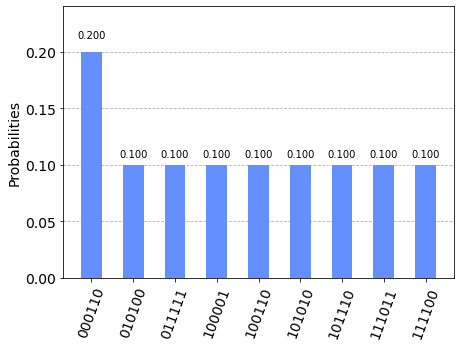

In [77]:
plot_histogram(retrieved_job.result().get_counts())

### Running algorithms

In [48]:
H2_op = (
    (-1.052373245772859 * I ^ I)
    + (0.39793742484318045 * I ^ Z)
    + (-0.39793742484318045 * Z ^ I)
    + (-0.01128010425623538 * Z ^ Z)
    + (0.18093119978423156 * X ^ X)
)

qi = QuantumInstance(local_simulator, seed_transpiler=42, seed_simulator=42)
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
slsqp = SLSQP(maxiter=1)

vqe = VQE(ansatz, optimizer=slsqp, quantum_instance=qi)

result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 9,
    'eigenstate': {   '00': 0.8454843286542927,
                      '01': 0.28125,
                      '10': 0.14986973510352247,
                      '11': 0.42847841252506524},
    'eigenvalue': (-0.9640051666453908+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -2.3927748649949567,
                              ParameterVectorElement(θ[1]): 2.4697879986238824,
                              ParameterVectorElement(θ[2]): -1.9005130390534406,
                              ParameterVectorElement(θ[3]): -2.5168166820743014,
                              ParameterVectorElement(θ[4]): -6.256884315134194,
                              ParameterVectorElement(θ[5]): -0.7574239815126385,
                              ParameterVectorElement(θ[6]): 0.7930414888274298,
                              ParameterVectorElement(θ[7]): -5.903305877757919},
    'optimal_point': array([-2.39277486,  2.469788  , -1.90

### Running Hybrid Jobs

Prepare script

In [51]:
! cat ./data/2_hybrid_jobs/job_script.py

"""Example of Hybrid Job payload with VQE."""
from braket.jobs import save_job_result
from qiskit.opflow import (
    I,
    X,
    Z,
)
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

from qiskit_braket_provider import AWSBraketProvider


def main():
    backend = AWSBraketProvider().get_backend("SV1")

    h2_op = (
        (-1.052373245772859 * I ^ I)
        + (0.39793742484318045 * I ^ Z)
        + (-0.39793742484318045 * Z ^ I)
        + (-0.01128010425623538 * Z ^ Z)
        + (0.18093119978423156 * X ^ X)
    )

    quantum_instance = QuantumInstance(
        backend, seed_transpiler=42, seed_simulator=42, shots=10
    )
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
    slsqp = SLSQP(maxiter=1)

    vqe = VQE(ansatz, optimizer=slsqp, quantum_instance=quantum_instance)

    vqe_result = vqe.compute_minimum_eigenvalue(h2_op)

    save_job_

Prepare image

In [53]:
! cat ./data/2_hybrid_jobs/Dockerfile

FROM 292282985366.dkr.ecr.us-west-2.amazonaws.com/amazon-braket-base-jobs:1.0-cpu-py37-ubuntu18.04

RUN python3 -m pip install --upgrade pip

RUN python3 -m pip install --no-cache --upgrade git+https://github.com/qiskit-community/qiskit-braket-provider


In [54]:
image_uri = "<ACCOUNT_ID>.dkr.ecr.<AWS_REGION>.amazonaws.com/amazon-braket-qiskit-provider:latest"

job = AwsQuantumJob.create(
    device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
    source_module="data/2_hybrid_jobs/job_script.py",
    entry_point="job_script:main",
    wait_until_complete=False,
    job_name="qiskit-braket-vqe-6",
    image_uri=image_uri,
)

In [66]:
# print(job.result())
AwsQuantumJob(os.environ["AWS_IONQ_SAVED_HYBRID_JOB_ARN"]).result()

{'VQE': {'eigenstate': {'01': 0.8366600265340756, '11': 0.5477225575051661},
  'eigenvalue': -1.6823050629682066,
  'optimal_parameters': [2.965910707685307,
   -4.658133055892289,
   -4.3956015975227265,
   -3.682189424847994,
   0.3499389384822065,
   -2.55160387237748,
   2.0897918250881915,
   1.0061448749802206],
  'optimal_point': [2.965910707685307,
   -4.658133055892289,
   -4.3956015975227265,
   -3.682189424847994,
   0.3499389384822065,
   -2.55160387237748,
   2.0897918250881915,
   1.0061448749802206],
  'optimal_value': -1.6823050629682066}}